In [1]:
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

In [159]:
shifts = {
    'EXT_DECAM': 50.,
    '': 5.,
    'EXT_OMEGACAM': -20.,
    'EXT_LSST': -50.,
    'EXT_JPCAM': 100.,
    'EXT_MEGACAM': -80,
    'EXT_PANSTARRS': -100,
    'EXT_HSC': 80
}
shift = 100
for k in shifts:
    shifts[k] = shift
config = dict()
exec(open('/home/aalvarez/Work/Data/SC8/PHZPRD_D3_3_NOMINAL_20211006T095754-37VOZ8CE-20211006-095828-003/data/Nnpz-12Jul2021-111557.conf').read(), config)
ref_bands = config['reference_sample_phot_filters']

In [160]:
# Patch the avg transmissions
hdul = fits.open('/home/aalvarez/Work/Data/SC8/PHZPRD_D3_3_NOMINAL_20211006T095754-37VOZ8CE-20211006-095828-003/PhotoShiftedWithCorr.fits')
target = Table.read('/home/aalvarez/Work/Data/SC8/PHZPRD_D3_3_NOMINAL_20211006T095754-37VOZ8CE-20211006-095828-003/GalaxyFilteringTask/galaxy_catalog.fits')

for t in hdul[2:]:
    if t.name == 'lsst/y':
        continue
    if t.name.startswith('euclid/'):
        bname = t.name.split('/')[1]
    else:
        bname = t.name.split('/')
        if bname[0] == 'des':
            bname[0] = 'decam'
        elif bname[0] == 'kids':
            bname[0] = 'omegacam'
        elif bname[0] == 'subaru':
            bname[0] = 'hsc'
        bname = f'{bname[1]}_EXT_{bname[0]}'.upper()
    avg_trans = np.average(t.data['Wavelength'], weights=t.data['Transmission'])
    colname = f'AVG_TRANS_WAVE_{bname}'
    print(colname, avg_trans)
    assert(colname in target.dtype.names)
    target[colname] = avg_trans
target.write('/home/aalvarez/Work/Data/SC8/PHZPRD_D3_3_NOMINAL_20211006T095754-37VOZ8CE-20211006-095828-003/GalaxyFilteringTask/galaxy_catalog_patched.fits', overwrite=True)

AVG_TRANS_WAVE_I_EXT_DECAM 7870.993
AVG_TRANS_WAVE_R_EXT_DECAM 6488.535
AVG_TRANS_WAVE_Z_EXT_DECAM 9222.344
AVG_TRANS_WAVE_G_EXT_DECAM 4891.8354
AVG_TRANS_WAVE_J 13689.144
AVG_TRANS_WAVE_VIS 7156.6636
AVG_TRANS_WAVE_Y 10866.99
AVG_TRANS_WAVE_H 17732.145
AVG_TRANS_WAVE_G_EXT_JPCAM 4887.657
AVG_TRANS_WAVE_U_EXT_OMEGACAM 3555.4653
AVG_TRANS_WAVE_I_EXT_OMEGACAM 7549.671
AVG_TRANS_WAVE_R_EXT_OMEGACAM 6278.1714
AVG_TRANS_WAVE_G_EXT_OMEGACAM 4708.244
AVG_TRANS_WAVE_U_EXT_LSST 3620.6987
AVG_TRANS_WAVE_I_EXT_LSST 7495.976
AVG_TRANS_WAVE_R_EXT_LSST 6173.24
AVG_TRANS_WAVE_Z_EXT_LSST 8640.901
AVG_TRANS_WAVE_G_EXT_LSST 4776.851
AVG_TRANS_WAVE_U_EXT_MEGACAM 3602.77
AVG_TRANS_WAVE_R_EXT_MEGACAM 6345.6978
AVG_TRANS_WAVE_I_EXT_PANSTARRS 7444.5713
AVG_TRANS_WAVE_Z_EXT_PANSTARRS 8579.496
AVG_TRANS_WAVE_Z_EXT_HSC 8991.536


In [161]:
for c in target.colnames:
    if c.startswith('AVG_TRANS_WAVE'):
        if 'EXT' in c:
            key = '_'.join(c.split('_')[4:])
            if key in shifts:
                target[c] += shifts[key]
            else:
                print(key)
        else:
            target[c] += shifts['']
target.write('/home/aalvarez/Work/Data/SC8/PHZPRD_D3_3_NOMINAL_20211006T095754-37VOZ8CE-20211006-095828-003/GalaxyFilteringTask/galaxy_catalog_shifted.fits', overwrite=True)

In [162]:
reference = Table.read('/home/aalvarez/Work/Data/SC8/PHZPRD_D3_3_NOMINAL_20211006T095754-37VOZ8CE-20211006-095828-003/ReferenceRun.fits', hdu=1)
shifted_not_corrected = Table.read('/home/aalvarez/Work/Data/SC8/PHZPRD_D3_3_NOMINAL_20211006T095754-37VOZ8CE-20211006-095828-003/ShiftedNoCorrected.fits', hdu=1)
shifted_corrected = Table.read('/home/aalvarez/Work/Data/SC8/PHZPRD_D3_3_NOMINAL_20211006T095754-37VOZ8CE-20211006-095828-003/ShiftedCorrected.fits', hdu=1)
reference = reference[:len(shifted_corrected)]

In [163]:
assert((shifted_corrected['OBJECT_ID'] == reference['OBJECT_ID']).all())
assert((shifted_not_corrected['OBJECT_ID'] == reference['OBJECT_ID']).all())

In [164]:
same_nn = (np.sort(reference['NEIGHBOR_IDS'], axis=1) == np.sort(shifted_not_corrected['NEIGHBOR_IDS'], axis=1)).sum(axis=1)
same_nn2 = (np.sort(reference['NEIGHBOR_IDS'], axis=1) == np.sort(shifted_corrected['NEIGHBOR_IDS'], axis=1)).sum(axis=1)
same_nn3 = (np.sort(shifted_not_corrected['NEIGHBOR_IDS'], axis=1) == np.sort(shifted_corrected['NEIGHBOR_IDS'], axis=1)).sum(axis=1)

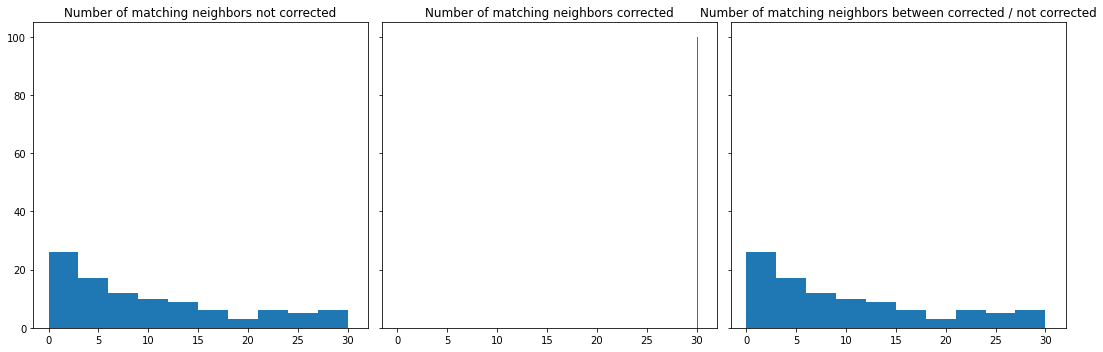

In [165]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)
axes[0].hist(same_nn)
axes[0].set_title('Number of matching neighbors not corrected')
axes[1].hist(same_nn2)
axes[1].set_title('Number of matching neighbors corrected')
axes[2].hist(same_nn3)
axes[2].set_title('Number of matching neighbors between corrected / not corrected')
plt.tight_layout()
plt.show()

In [166]:
rw = np.sort(reference['NEIGHBOR_WEIGHTS'] / reference['NEIGHBOR_WEIGHTS'].sum(axis=1, keepdims=True), axis=1)
cw = np.sort(shifted_corrected['NEIGHBOR_WEIGHTS'] / shifted_corrected['NEIGHBOR_WEIGHTS'].sum(axis=1, keepdims=True), axis=1)
ncw = np.sort(shifted_not_corrected['NEIGHBOR_WEIGHTS'] / shifted_not_corrected['NEIGHBOR_WEIGHTS'].sum(axis=1, keepdims=True), axis=1)

/opt/miniconda3/envs/phz/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/opt/miniconda3/envs/phz/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/opt/miniconda3/envs/phz/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


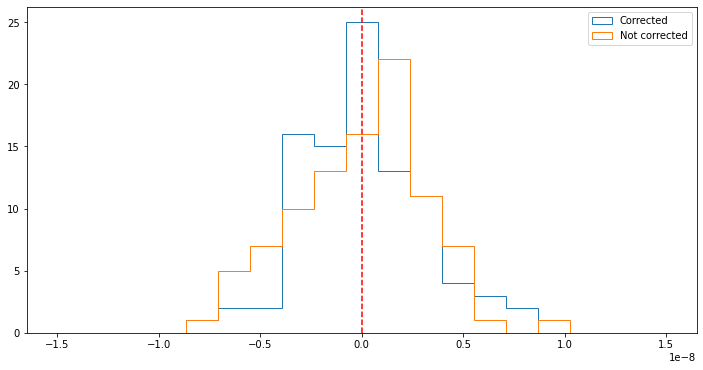

In [167]:
bins = np.linspace(-1.5, 1.5, 20) * 1e-8
plt.figure(figsize=(12, 6))
plt.hist((cw - rw).mean(axis=1), histtype='step', label='Corrected', bins=bins)
plt.hist((ncw - rw).mean(axis=1), histtype='step', label='Not corrected', bins=bins)
plt.axvline(0, c='red', linestyle='--')
plt.legend()
plt.show()

In [168]:
np.nanmean(np.abs(cw - rw).sum(axis=1))

0.020257892

In [169]:
np.nanmean(np.abs(ncw - rw).sum(axis=1))

0.21317017

In [170]:
shifted_corrected['NEIGHBOR_WEIGHTS'][0]

array([1.21541254e-01, 2.72608940e-02, 1.64308529e-02, 2.95865238e-02,
       1.54461889e-02, 2.43322216e-02, 1.46632325e-02, 6.16530403e-02,
       1.32172322e-02, 2.62741689e-02, 1.50969569e-02, 9.15730372e-03,
       2.28062049e-02, 2.09565405e-02, 2.04591881e-02, 1.57946926e-02,
       8.69698729e-03, 8.46355036e-03, 9.68730450e-03, 1.53891398e-02,
       1.44475792e-02, 8.85358732e-03, 9.24414955e-03, 1.32182026e-02,
       4.79784823e-04, 2.96905404e-03, 1.43091008e-02, 1.12659428e-02,
       5.70528535e-03, 4.38663192e-05], dtype=float32)

In [171]:
shifted_not_corrected['NEIGHBOR_WEIGHTS'][0]

array([0.06364292, 0.05650496, 0.0463273 , 0.02901486, 0.02519862,
       0.02235137, 0.02230874, 0.02107821, 0.02052993, 0.01914608,
       0.01810883, 0.017852  , 0.01740576, 0.01626707, 0.01596466,
       0.01577474, 0.01476362, 0.01305062, 0.01209338, 0.01206129,
       0.01161086, 0.01107179, 0.01053637, 0.01005655, 0.00989386,
       0.00933878, 0.00893419, 0.0077804 , 0.00775223, 0.00774081],
      dtype=float32)

In [172]:
reference['NEIGHBOR_WEIGHTS'][0]

array([0.12119194, 0.02791248, 0.01640078, 0.02884993, 0.01631959,
       0.02405039, 0.01467139, 0.06129513, 0.01334805, 0.02583574,
       0.01536097, 0.00876151, 0.02260306, 0.02051715, 0.02033915,
       0.01401021, 0.00863148, 0.00864869, 0.00980107, 0.01754962,
       0.01478574, 0.0089003 , 0.00933109, 0.01340309, 0.0015463 ,
       0.00381234, 0.01475694, 0.0109867 , 0.00573627, 0.00020357],
      dtype=float32)

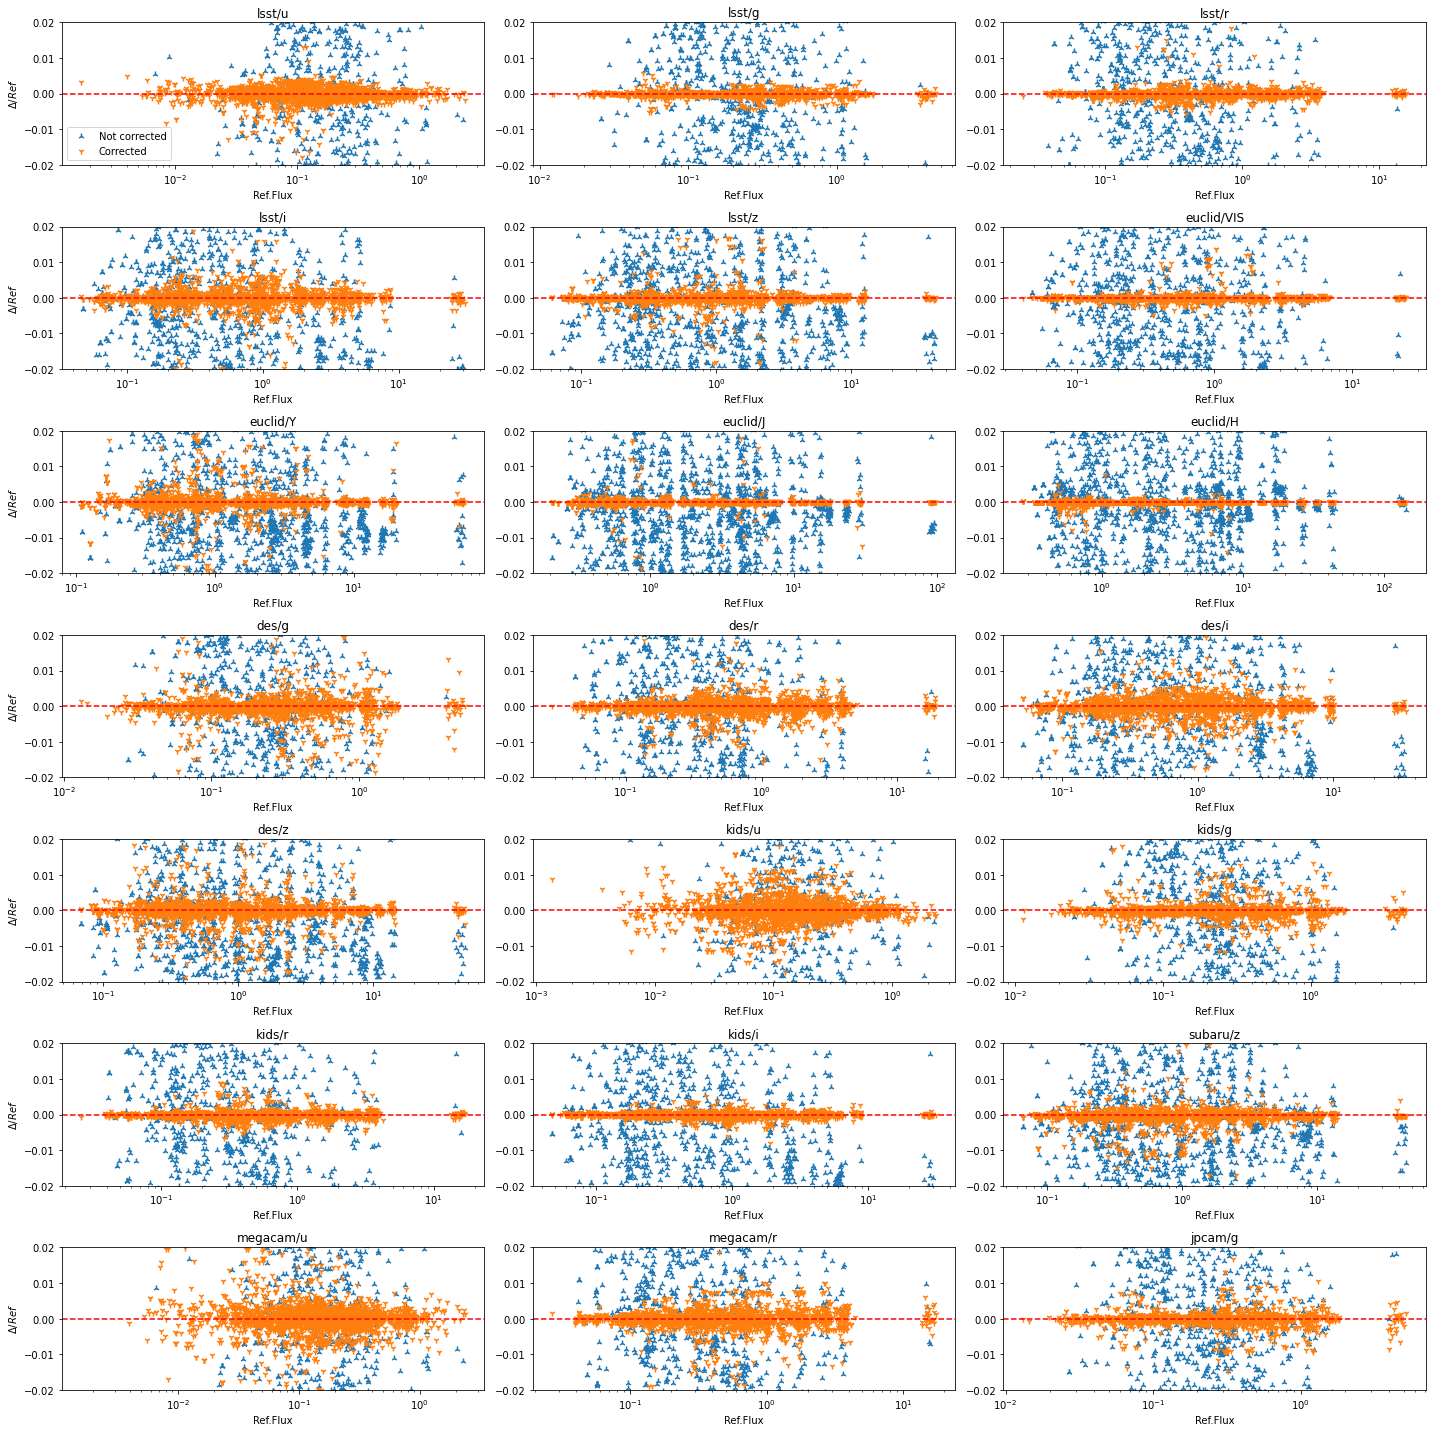

In [176]:
fig, axes = plt.subplots(ncols=3, nrows=len(ref_bands)//3, figsize=(20, 20))

for i, ax in enumerate(axes.ravel()):
    b = ref_bands[i]
    ax.set_title(b)
    ref_photo = reference[f'NEIGHBOR_PHOTOMETRY_{b}']
    corr_photo = shifted_corrected[f'NEIGHBOR_PHOTOMETRY_{b}']
    nocorr_photo = shifted_not_corrected[f'NEIGHBOR_PHOTOMETRY_{b}']
    ax.scatter(ref_photo, (nocorr_photo-ref_photo) / ref_photo, label='Not corrected', marker='2')
    ax.scatter(ref_photo, (corr_photo-ref_photo) / ref_photo, label='Corrected', marker='1')
    ax.set_xscale('log')
    ax.axhline(0, color='red', linestyle='--')
    if i == 0:
        ax.legend()
    ax.set_xlabel('Ref.Flux')
    if i % 3 == 0:
        ax.set_ylabel('$\\Delta / Ref$')
    ax.set_ylim(-0.02, 0.02)

plt.savefig(f'/home/aalvarez/Downloads/Shift/{shift}.png')
plt.tight_layout()